# Exercise 1

## Analyze how travelers expressed their feelings on Twitter

A sentiment analysis job about the problems of each major U.S. airline.
Twitter data was scraped from February of 2015 and contributors were
asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# read the data and set the datetime as the index
tweets = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/Tweets.zip', index_col=0)

tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [2]:
tweets.shape

(14640, 14)

### Proportion of tweets with each sentiment

In [3]:
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

### Proportion of tweets per airline


In [4]:
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

<Axes: xlabel='airline'>

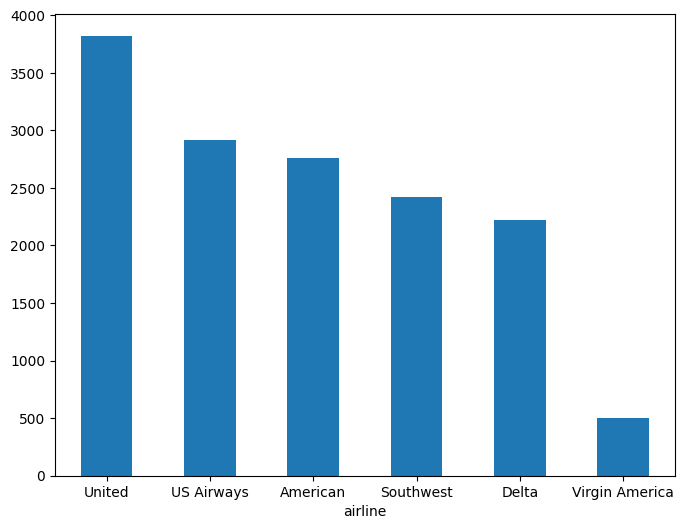

In [5]:
pd.Series(tweets["airline"]).value_counts().plot(kind = "bar",figsize=(8,6),rot = 0)

<Axes: title={'center': 'Sentiment by airline'}, xlabel='airline'>

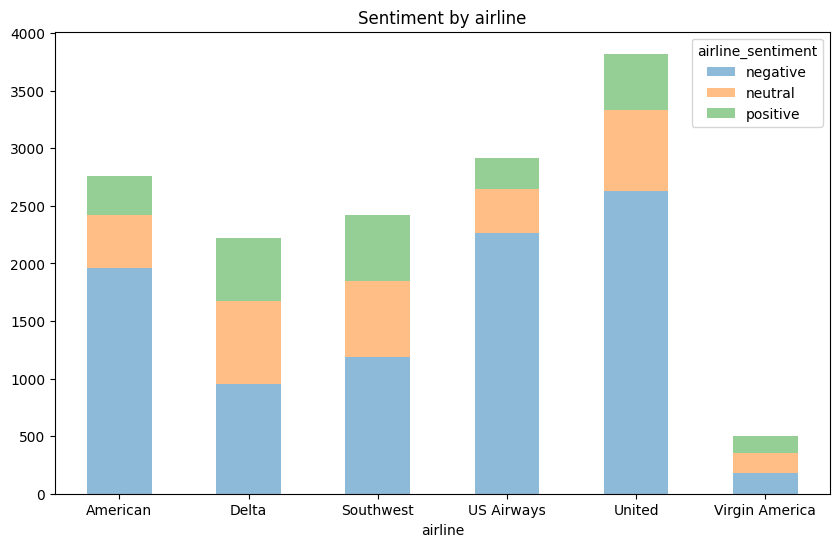

In [6]:
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiment by airline")

# Exercise 1.1

Predict the sentiment using CountVectorizer

use Random Forest classifier

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics import classification_report, accuracy_score, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

Limpieza de datos

In [8]:
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [9]:
import re
X = [
    ' '.join(word for word in re.sub(r"[.,;:'']", '', doc.lower()).split() )
    for doc in X
]

In [10]:
# Mostrar los primeros 5 tweets limpios
for tweet in X[:50]:
    print(tweet)

@virginamerica what @dhepburn said
@virginamerica plus youve added commercials to the experience tacky
@virginamerica i didnt today must mean i need to take another trip!
@virginamerica its really aggressive to blast obnoxious "entertainment" in your guests faces &amp they have little recourse
@virginamerica and its a really big bad thing about it
@virginamerica seriously would pay $30 a flight for seats that didnt have this playing its really the only bad thing about flying va
@virginamerica yes nearly every time i fly vx this “ear worm” won’t go away )
@virginamerica really missed a prime opportunity for men without hats parody there https//tco/mwpg7grezp
@virginamerica well i didnt…but now i do! -d
@virginamerica it was amazing and arrived an hour early youre too good to me
@virginamerica did you know that suicide is the second leading cause of death among teens 10-24
@virginamerica i &lt3 pretty graphics so much better than minimal iconography d
@virginamerica this is such a great 

Descargar recursos para lematizacion

In [11]:
# Descargar recursos necesarios para lematización
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

Crear funciones de steaming

In [13]:
from nltk.tokenize import WhitespaceTokenizer

In [14]:
stemmer = SnowballStemmer("english")
tk = WhitespaceTokenizer()

# Tokenización y stemming
def tokenize_and_stem(text):
    tokens = tk.tokenize(text)  # Tokenización por espacios
    stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Aplicar stemming
    return ' '.join(stemmed_tokens)  # Recomponer el texto

# Aplicar la función a los textos

lemmatizer = WordNetLemmatizer()

# Tokenización y lematización
def tokenize_and_lemmatize(text):
    tokens = tk.tokenize(text)  # Tokenización por espacios
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Aplicar lematización
    return ' '.join(lemmatized_tokens)  # Recomponer el texto

# Aplicar la función a los textos


In [15]:
X = tweets['text'].apply(tokenize_and_stem)
X.head()

tweet_id
570306133677760513                  @virginamerica what @dhepburn said.
570301130888122368    @virginamerica plus you'v ad commerci to the e...
570301083672813571    @virginamerica i didn't today... must mean i n...
570301031407624196    @virginamerica it realli aggress to blast obno...
570300817074462722    @virginamerica and it a realli big bad thing a...
Name: text, dtype: object

In [16]:
#X = tweets['text'].apply(tokenize_and_lemmatize)
#X.head()

Vectorizar el texto

In [17]:
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)
print(X_vectorized.shape)

(14640, 14223)


División del conjunto de train y test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

          -1       0.88      0.78      0.83      1889
           0       0.50      0.64      0.56       580
           1       0.62      0.71      0.66       459

    accuracy                           0.74      2928
   macro avg       0.67      0.71      0.68      2928
weighted avg       0.77      0.74      0.75      2928

Precisión: 0.7397540983606558
AUC: 0.8758960779880507


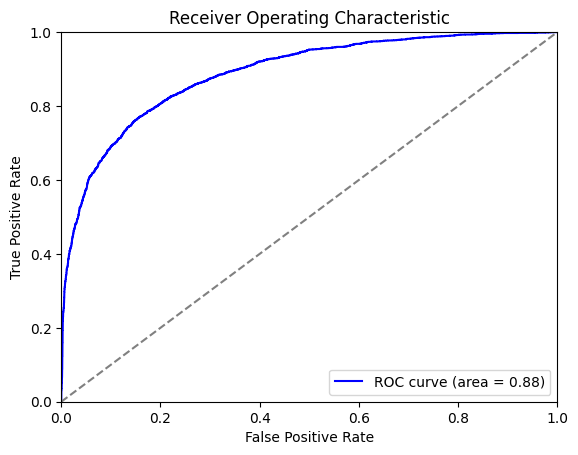

In [19]:
classifier = RandomForestClassifier(
    n_estimators=200,         # Aumentamos el número de árboles
    max_depth=15,             # Limitamos la profundidad máxima de los árboles
    min_samples_split=10,     # Requerimos un número mayor de muestras para dividir un nodo
    min_samples_leaf=4,       # Aumentamos el número mínimo de muestras en cada hoja
    max_features='sqrt',      # Consideramos la raíz cuadrada del número total de características
    random_state=42,
    class_weight='balanced'
)

classifier.fit(X_train, y_train)


# Predicciones
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)

# Evaluación del modelo
print(classification_report(y_test, y_pred))
print(f"Precisión: {accuracy_score(y_test, y_pred)}")

# Cálculo del AUC
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
print(f"AUC: {auc}")

# Graficar la curva ROC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc:0.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Exercise 1.2

Remove stopwords, then predict the sentiment using CountVectorizer.

use Random Forest classifier

llenado de arreglo con stop words

In [20]:
from nltk.corpus import stopwords
# Descargar las stopwords si no están ya descargadas
nltk.download('stopwords')

# Obtener las stopwords en inglés
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Modificion de funciones de steaming y lematizacion

In [21]:
lemmatizer = WordNetLemmatizer()
def tokenize_and_stem(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(stemmed_tokens)

stemmer = SnowballStemmer("english")
def tokenize_and_lemmatize(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(lemmatized_tokens)


Escoger uno de los dos

In [22]:
X = tweets['text'].apply(tokenize_and_lemmatize)

In [23]:
X = tweets['text'].apply(tokenize_and_stem)

In [24]:
vectorizer = CountVectorizer(stop_words='english')
X_vectorized = vectorizer.fit_transform(X)
print(X_vectorized.shape)

(14640, 13954)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

          -1       0.89      0.72      0.80      1889
           0       0.45      0.68      0.54       580
           1       0.65      0.71      0.68       459

    accuracy                           0.71      2928
   macro avg       0.66      0.71      0.67      2928
weighted avg       0.76      0.71      0.73      2928

Precisión: 0.7134562841530054
AUC: 0.8629645095828042


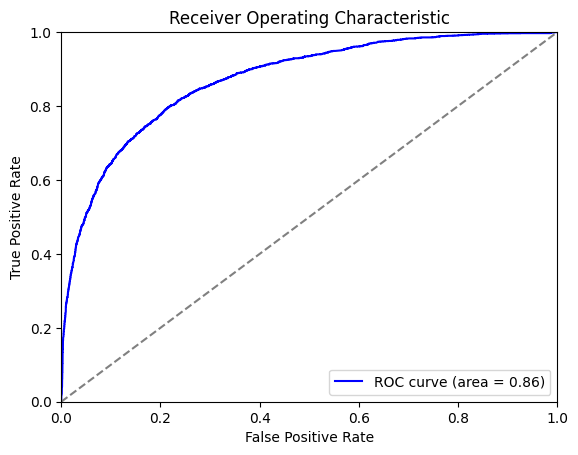

In [26]:
classifier = RandomForestClassifier(
    n_estimators=200,         # Aumentamos el número de árboles
    max_depth=15,             # Limitamos la profundidad máxima de los árboles
    min_samples_split=10,     # Requerimos un número mayor de muestras para dividir un nodo
    min_samples_leaf=4,       # Aumentamos el número mínimo de muestras en cada hoja
    max_features='sqrt',      # Consideramos la raíz cuadrada del número total de características
    random_state=42,
    class_weight='balanced'
)

classifier.fit(X_train, y_train)


# Predicciones
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)

# Evaluación del modelo
print(classification_report(y_test, y_pred))
print(f"Precisión: {accuracy_score(y_test, y_pred)}")

# Cálculo del AUC
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
print(f"AUC: {auc}")

# Graficar la curva ROC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc:0.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Exercise 1.3

Increase n_grams size (with and without stopwords),  then predict the sentiment using CountVectorizer

use Random Forest classifier

In [27]:
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
# Tokenización y stemming

def tokenize_and_stem_with_stop(text):
    tokens = text.split()  # Tokenización por espacios
    stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Aplicar stemming
    return ' '.join(stemmed_tokens)  # Recomponer el texto
# Tokenización y lematización

def tokenize_and_lemmatize_with_stop(text):
    tokens = text.split()  # Tokenización por espacios
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Aplicar lematización
    return ' '.join(lemmatized_tokens)  # Recomponer el texto

def tokenize_and_stem(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(stemmed_tokens)

def tokenize_and_lemmatize(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(lemmatized_tokens)



# con Stop Word

              precision    recall  f1-score   support

          -1       0.89      0.79      0.84      1889
           0       0.53      0.67      0.59       580
           1       0.63      0.70      0.66       459

    accuracy                           0.75      2928
   macro avg       0.68      0.72      0.70      2928
weighted avg       0.78      0.75      0.76      2928

Precisión: 0.7537568306010929
AUC: 0.8787748056522874


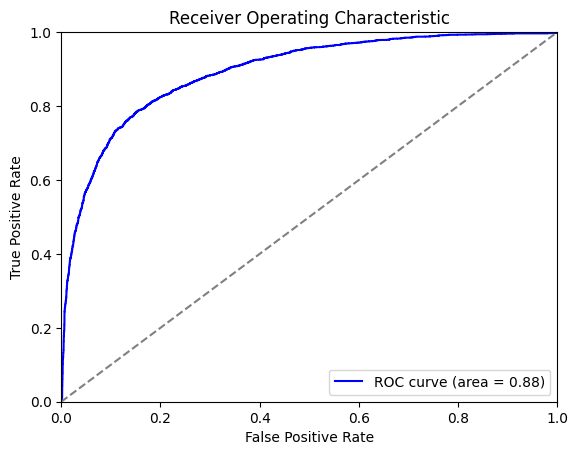

In [28]:
X = tweets['text'].apply(tokenize_and_stem_with_stop)

vectorizer_with_stopwords = CountVectorizer(ngram_range=(1, 4))
X_vectorized_with_stopwords = vectorizer_with_stopwords.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_vectorized_with_stopwords, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(
    n_estimators=200,         # Aumentamos el número de árboles
    max_depth=15,             # Limitamos la profundidad máxima de los árboles
    min_samples_split=10,     # Requerimos un número mayor de muestras para dividir un nodo
    min_samples_leaf=4,       # Aumentamos el número mínimo de muestras en cada hoja
    max_features='sqrt',      # Consideramos la raíz cuadrada del número total de características
    random_state=42,
    class_weight='balanced'
)

classifier.fit(X_train, y_train)


# Predicciones
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)

# Evaluación del modelo
print(classification_report(y_test, y_pred))
print(f"Precisión: {accuracy_score(y_test, y_pred)}")

# Cálculo del AUC
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
print(f"AUC: {auc}")

# Graficar la curva ROC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc:0.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# sin Stop Words

              precision    recall  f1-score   support

          -1       0.89      0.78      0.83      1889
           0       0.49      0.68      0.57       580
           1       0.66      0.70      0.68       459

    accuracy                           0.75      2928
   macro avg       0.68      0.72      0.69      2928
weighted avg       0.78      0.75      0.76      2928

Precisión: 0.7469262295081968
AUC: 0.8684303957287667


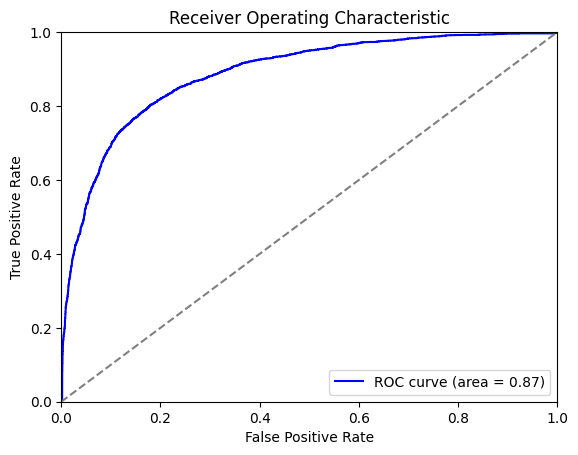

In [29]:
X = tweets['text'].apply(tokenize_and_stem)

vectorizer_without_stopwords = CountVectorizer(ngram_range=(1, 4),stop_words='english')
X_vectorized_without_stopwords = vectorizer_with_stopwords.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_vectorized_without_stopwords, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(
    n_estimators=200,         # Aumentamos el número de árboles
    max_depth=15,             # Limitamos la profundidad máxima de los árboles
    min_samples_split=10,     # Requerimos un número mayor de muestras para dividir un nodo
    min_samples_leaf=4,       # Aumentamos el número mínimo de muestras en cada hoja
    max_features='sqrt',      # Consideramos la raíz cuadrada del número total de características
    random_state=42,
    class_weight='balanced'
)

classifier.fit(X_train, y_train)


# Predicciones
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)

# Evaluación del modelo
print(classification_report(y_test, y_pred))
print(f"Precisión: {accuracy_score(y_test, y_pred)}")

# Cálculo del AUC
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
print(f"AUC: {auc}")

# Graficar la curva ROC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc:0.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Exercise 1.4

Predict the sentiment using TfidfVectorizer.

use Random Forest classifier

              precision    recall  f1-score   support

          -1       0.88      0.77      0.82      1889
           0       0.48      0.64      0.55       580
           1       0.63      0.68      0.65       459

    accuracy                           0.73      2928
   macro avg       0.66      0.69      0.67      2928
weighted avg       0.76      0.73      0.74      2928

Precisión: 0.7281420765027322
AUC: 0.8586928640393684


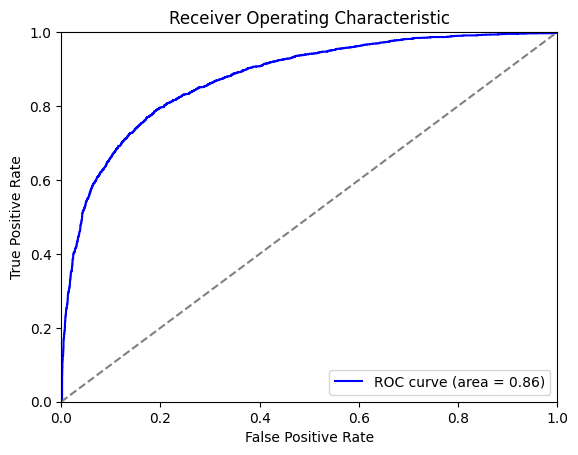

In [30]:
def tokenize_and_stem(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(stemmed_tokens)

X = tweets['text'].apply(tokenize_and_stem)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 4),stop_words='english')  # Puedes ajustar el rango de n-grams si lo deseas
X_vectorized_tfidf = tfidf_vectorizer.fit_transform(X)

y = tweets['airline_sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
X_train, X_test, y_train, y_test = train_test_split(X_vectorized_tfidf, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(
    n_estimators=200,         # Aumentamos el número de árboles
    max_depth=15,             # Limitamos la profundidad máxima de los árboles
    min_samples_split=10,     # Requerimos un número mayor de muestras para dividir un nodo
    min_samples_leaf=4,       # Aumentamos el número mínimo de muestras en cada hoja
    max_features='sqrt',      # Consideramos la raíz cuadrada del número total de características
    random_state=42,
    class_weight='balanced'
)

classifier.fit(X_train, y_train)


# Predicciones
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)

# Evaluación del modelo
print(classification_report(y_test, y_pred))
print(f"Precisión: {accuracy_score(y_test, y_pred)}")

# Cálculo del AUC
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
print(f"AUC: {auc}")

# Graficar la curva ROC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc:0.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()